Files already downloaded and verified
Files already downloaded and verified
Epoch [1/16], Loss: 1.2692
Epoch [2/16], Loss: 0.8807
Epoch [3/16], Loss: 0.6971
Epoch [4/16], Loss: 0.5378
Epoch [5/16], Loss: 0.3853
Epoch [6/16], Loss: 0.2497
Epoch [7/16], Loss: 0.1490
Epoch [8/16], Loss: 0.1007
Epoch [9/16], Loss: 0.0738
Epoch [10/16], Loss: 0.0695
Epoch [11/16], Loss: 0.0627
Epoch [12/16], Loss: 0.0529
Epoch [13/16], Loss: 0.0494
Epoch [14/16], Loss: 0.0450
Epoch [15/16], Loss: 0.0541
Epoch [16/16], Loss: 0.0406
Accuracy on adversarial examples: 8.66%
Average confidence on incorrect predictions: 89.89%


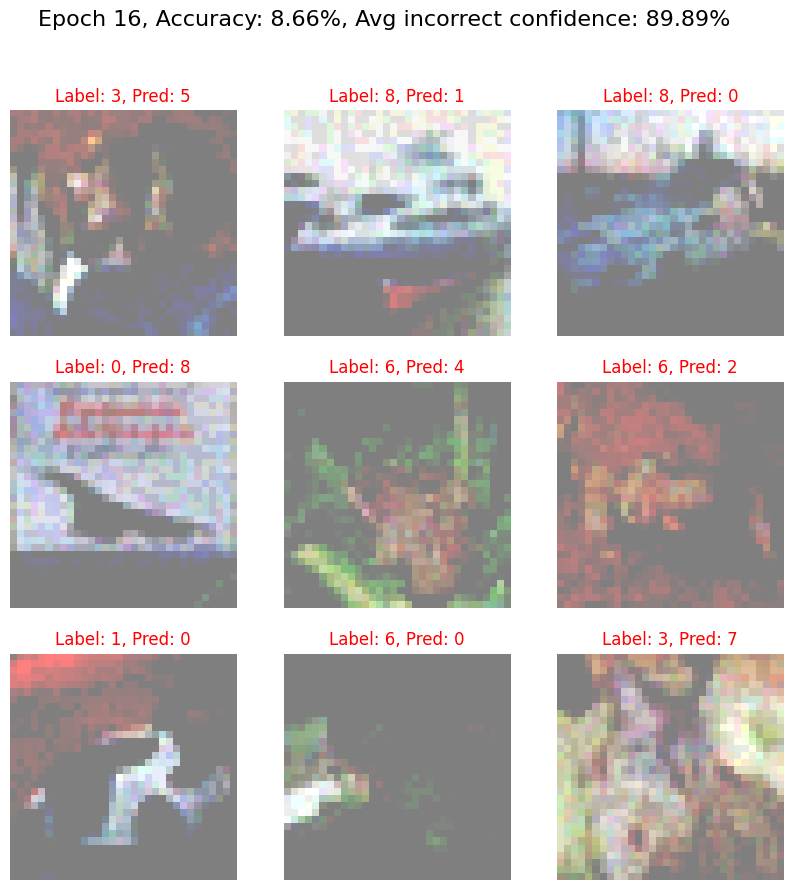

In [3]:
# ----------------------------
# Imports
# ----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# ----------------------------
# Définition de l'attaque FGSM
# ----------------------------
def FGSM(model, images, labels, epsilon):
    """
    Génère des exemples adversariaux avec FGSM.
    """
    images.requires_grad = True
    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)
    
    return adversarial_images

# ----------------------------
# Définition du modèle CNN avec Maxout
# ----------------------------
class ConvMaxoutNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*8*8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(2, 2)  # utilisé comme "maxout"

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64*8*8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ----------------------------
# Chargement des données CIFAR-10
# ----------------------------
def load_data(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# ----------------------------
# Entraînement sur données normales
# ----------------------------
def train_model(model, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# ----------------------------
# Test sur données adversariales
# ----------------------------
def test_adversarial(model, test_loader, epsilon):
    model.eval()
    correct = 0
    total = 0
    incorrect_probs = []

    for images, labels in test_loader:
        adv_images = FGSM(model, images, labels, epsilon)
        outputs = model(adv_images)
        probs = nn.Softmax(dim=1)(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:
                incorrect_probs.append(probs[i, predicted[i]].item())

    accuracy = 100 * correct / total
    avg_incorrect_prob = np.mean(incorrect_probs)*100 if incorrect_probs else 0

    print(f'Accuracy on adversarial examples: {accuracy:.2f}%')
    if incorrect_probs:
        print(f'Average confidence on incorrect predictions: {avg_incorrect_prob:.2f}%')
    else:
        print('No incorrect predictions to calculate average confidence.')

    return accuracy, avg_incorrect_prob

# ----------------------------
# Visualisation des images adversariales
# ----------------------------
def plot_adversarial_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        img = images[i].detach().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
        plt.imshow(img)
        color = 'g' if labels[i] == predictions[i] else 'r'
        plt.title(f"Label: {labels[i]}, Pred: {predictions[i]}", color=color)
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}, Accuracy: {accuracy:.2f}%, Avg incorrect confidence: {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# ----------------------------
# Fonction principale
# ----------------------------
def main():
    epsilon = 0.1
    epochs = 16

    train_loader, test_loader = load_data()
    model = ConvMaxoutNet()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, optimizer, epochs)
    accuracy, avg_incorrect_prob = test_adversarial(model, test_loader, epsilon)

    # Visualisation
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    adv_images = FGSM(model, images, labels, epsilon)
    outputs = model(adv_images)
    _, predictions = torch.max(outputs, 1)
    plot_adversarial_images(adv_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# ----------------------------
# Exécution
# ----------------------------
if __name__ == "__main__":
    main()


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/20], Loss: 1.5204
Epoch [2/20], Loss: 1.0539
Epoch [3/20], Loss: 0.8550
Epoch [4/20], Loss: 0.6842
Epoch [5/20], Loss: 0.5377
Epoch [6/20], Loss: 0.3937
Epoch [7/20], Loss: 0.2682
Epoch [8/20], Loss: 0.1667
Epoch [9/20], Loss: 0.0988
Epoch [10/20], Loss: 0.0601
Epoch [11/20], Loss: 0.0397
Epoch [12/20], Loss: 0.0307
Epoch [13/20], Loss: 0.0265
Epoch [14/20], Loss: 0.0096
Epoch [15/20], Loss: 0.0060
Epoch [16/20], Loss: 0.0029
Epoch [17/20], Loss: 0.0005
Epoch [18/20], Loss: 0.0003
Epoch [19/20], Loss: 0.0003
Epoch [20/20], Loss: 0.0002
Accuracy on adversarial examples: 11.11%
Average confidence on incorrect predictions: 90.23%


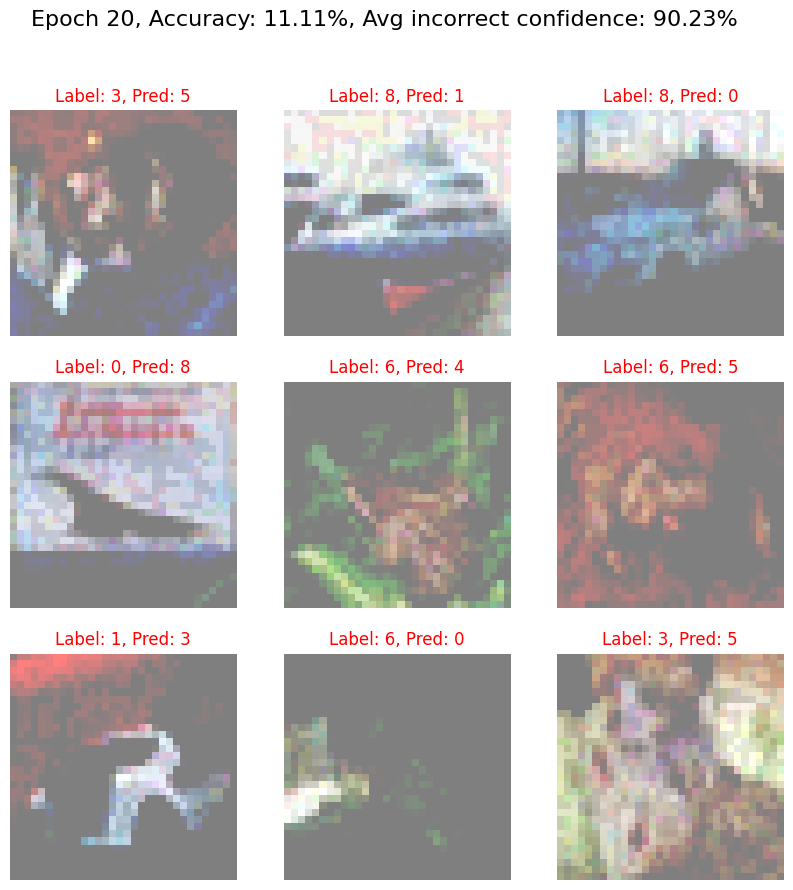

In [1]:
# ----------------------------
# Imports
# ----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# ----------------------------
# Définition de l'attaque FGSM
# ----------------------------
def FGSM(model, images, labels, epsilon):
    """
    Génère des exemples adversariaux avec FGSM.
    """
    images.requires_grad = True
    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)
    
    return adversarial_images

# ----------------------------
# Définition du modèle CNN avec Maxout
# ----------------------------
class ConvMaxoutNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*8*8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(2, 2)  # utilisé comme "maxout"

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64*8*8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ----------------------------
# Chargement des données CIFAR-10
# ----------------------------
def load_data(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# ----------------------------
# Entraînement sur données normales
# ----------------------------
def train_model(model, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# ----------------------------
# Test sur données adversariales
# ----------------------------
def test_adversarial(model, test_loader, epsilon):
    model.eval()
    correct = 0
    total = 0
    incorrect_probs = []

    for images, labels in test_loader:
        adv_images = FGSM(model, images, labels, epsilon)
        outputs = model(adv_images)
        probs = nn.Softmax(dim=1)(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:
                incorrect_probs.append(probs[i, predicted[i]].item())

    accuracy = 100 * correct / total
    avg_incorrect_prob = np.mean(incorrect_probs)*100 if incorrect_probs else 0

    print(f'Accuracy on adversarial examples: {accuracy:.2f}%')
    if incorrect_probs:
        print(f'Average confidence on incorrect predictions: {avg_incorrect_prob:.2f}%')
    else:
        print('No incorrect predictions to calculate average confidence.')

    return accuracy, avg_incorrect_prob

# ----------------------------
# Visualisation des images adversariales
# ----------------------------
def plot_adversarial_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        img = images[i].detach().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
        plt.imshow(img)
        color = 'g' if labels[i] == predictions[i] else 'r'
        plt.title(f"Label: {labels[i]}, Pred: {predictions[i]}", color=color)
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}, Accuracy: {accuracy:.2f}%, Avg incorrect confidence: {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# ----------------------------
# Fonction principale
# ----------------------------
def main():
    epsilon = 0.1
    epochs = 20

    train_loader, test_loader = load_data()
    model = ConvMaxoutNet()
    
    # Utilisation de SGD avec momentum
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_model(model, train_loader, optimizer, epochs)
    accuracy, avg_incorrect_prob = test_adversarial(model, test_loader, epsilon)

    # Visualisation
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    adv_images = FGSM(model, images, labels, epsilon)
    outputs = model(adv_images)
    _, predictions = torch.max(outputs, 1)
    plot_adversarial_images(adv_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# ----------------------------
# Exécution
# ----------------------------
if __name__ == "__main__":
    main()
